# Test 1 : Stability of the environment

- See if: the environment is working without bugs (reset, step, featurisation)
- SB3 PPO accept the env 
- The training loop run (200k steps without error)
- and the modele is saving

In [1]:
from stable_baselines3 import PPO
from env.overcooked_wrapper import OvercookedGym

env = OvercookedGym("cramped_room", agent_index=0)

Computing MediumLevelActionManager
Computing MediumLevelActionManager


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [2]:
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=200_000)
model.save("ppo_student_teacher")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Computing MediumLevelActionManager
Computing MediumLevelActionManager
Computing MediumLevelActionManager
Computing MediumLevelActionManager
Computing MediumLevelActionManager
Computing MediumLevelActionManager
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 400      |
|    ep_rew_mean     | 96       |
| time/              |          |
|    fps             | 605      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
Computing MediumLevelActionManager
Computing MediumLevelActionManager
Computing MediumLevelActionManager
Computing MediumLevelActionManager
Computing MediumLevelActionManager
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 74          |
| time/      

# test 2 : Does the PPO learn with the teacher

In [3]:
from stable_baselines3 import PPO
from env.overcooked_wrapper import OvercookedGym

env = OvercookedGym("cramped_room", agent_index=0)
model = PPO.load("ppo_student_teacher")

obs, _ = env.reset()
total = 0

for t in range(400):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    total += reward
    if done:
        break

print("Reward with teacher:", total)

Computing MediumLevelActionManager
Computing MediumLevelActionManager
Computing MediumLevelActionManager
Reward with teacher: 180


# Test 3 : Official Evaluation with AgentEvaluator 

In [4]:
from overcooked_ai_py.agents.agent import AgentPair
from overcooked_ai_py.agents.benchmarking import AgentEvaluator
from student.ppo_student_agent import PPOStudentAgent
from stable_baselines3 import PPO
from overcooked_ai_py.mdp.overcooked_mdp import OvercookedGridworld
from overcooked_ai_py.mdp.overcooked_env import OvercookedEnv

model = PPO.load("ppo_student_teacher")

mdp = OvercookedGridworld.from_layout_name("cramped_room", old_dynamics=True)
base_env = OvercookedEnv.from_mdp(mdp, horizon=400)
featurize_fn = base_env.featurize_state_mdp

student0 = PPOStudentAgent(model, featurize_fn, 0)
student1 = PPOStudentAgent(model, featurize_fn, 1)

pair = AgentPair(student0, student1, allow_duplicate_agents=True)

ae = AgentEvaluator.from_layout_name(
    mdp_params={"layout_name": "cramped_room", "old_dynamics": True},
    env_params={"horizon": 400},
)

results = ae.evaluate_agent_pair(pair, num_games=5)
print(results["ep_returns"])
print("Average:", sum(results["ep_returns"]) / len(results["ep_returns"]))

  0%|          | 0/5 [00:00<?, ?it/s]

Computing MediumLevelActionManager


Avg rew: 0.00 (std: 0.00, se: 0.00); avg len: 400.00; : 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]

Skipping trajectory consistency checking because MDP was recognized as variable. Trajectory consistency checking is not yet supported for variable MDPs.
[0 0 0 0 0]
Average: 0.0



=== cramped_room ===
XXPXX
O   O
X   X
XDXSX


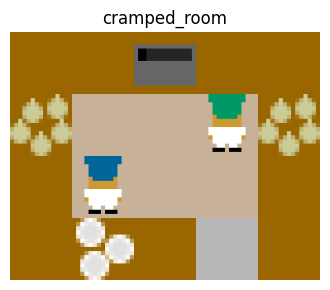


=== counter_circuit_o_1order ===
XXXPPXXX
X      X
D XXXX S
X      X
XXXOOXXX


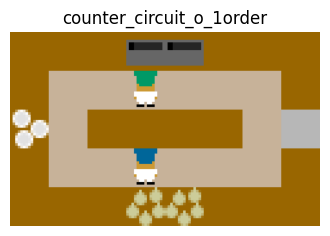


=== forced_coordination ===
XXXPX
O X P
O X X
D X X
XXXSX


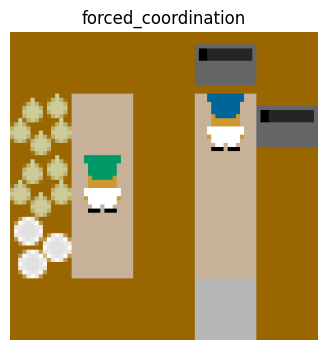


=== coordination_ring ===
XXXPX
X   P
D X X
O   X
XOSXX


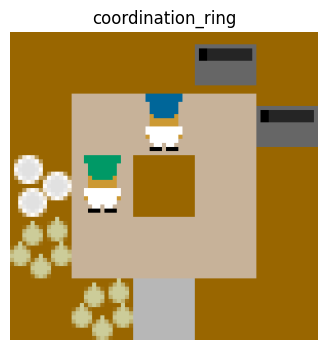

In [ ]:


import matplotlib.pyplot as plt
import numpy as np
import pygame

from overcooked_ai_py.mdp.overcooked_mdp import OvercookedGridworld
from overcooked_ai_py.mdp.overcooked_env import OvercookedEnv
from overcooked_ai_py.visualization.state_visualizer import StateVisualizer

pygame.init()


LAYOUT_NAMES = [
    "cramped_room",
    "counter_circuit_o_1order",
    "forced_coordination",
    "coordination_ring",
]


def show_layout(layout_name):
    print(f"\n=== {layout_name} ===")

    
    mdp = OvercookedGridworld.from_layout_name(layout_name)
    env = OvercookedEnv.from_mdp(mdp, horizon=400)

   
    for row in mdp.terrain_mtx:
        print("".join(row))
    
    
    vis = StateVisualizer()

   
    surface = vis.render_state(env.state, mdp.terrain_mtx)

    arr = pygame.surfarray.array3d(surface)
    arr = np.rot90(arr, k=3)           
    arr = np.fliplr(arr)               

    plt.figure(figsize=(4, 4))
    plt.imshow(arr)
    plt.axis("off")
    plt.title(layout_name)
    plt.show()



for name in LAYOUT_NAMES:
    show_layout(name)
